# 基于物理公式进行特征选择的关于e_electronic模型 

[TOC]

## 进行特征清洗 

- **去除掉相关性较强的俩个特征中的一个** ----- Pearson相关系数

In [14]:
# 导库
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression

In [2]:
# 一些参数
TEST_SIZE = 0.30
RANDOM_STATE = 42
N_SPLITS = 10
# 决策树的深度
BEST_DEPTH = None

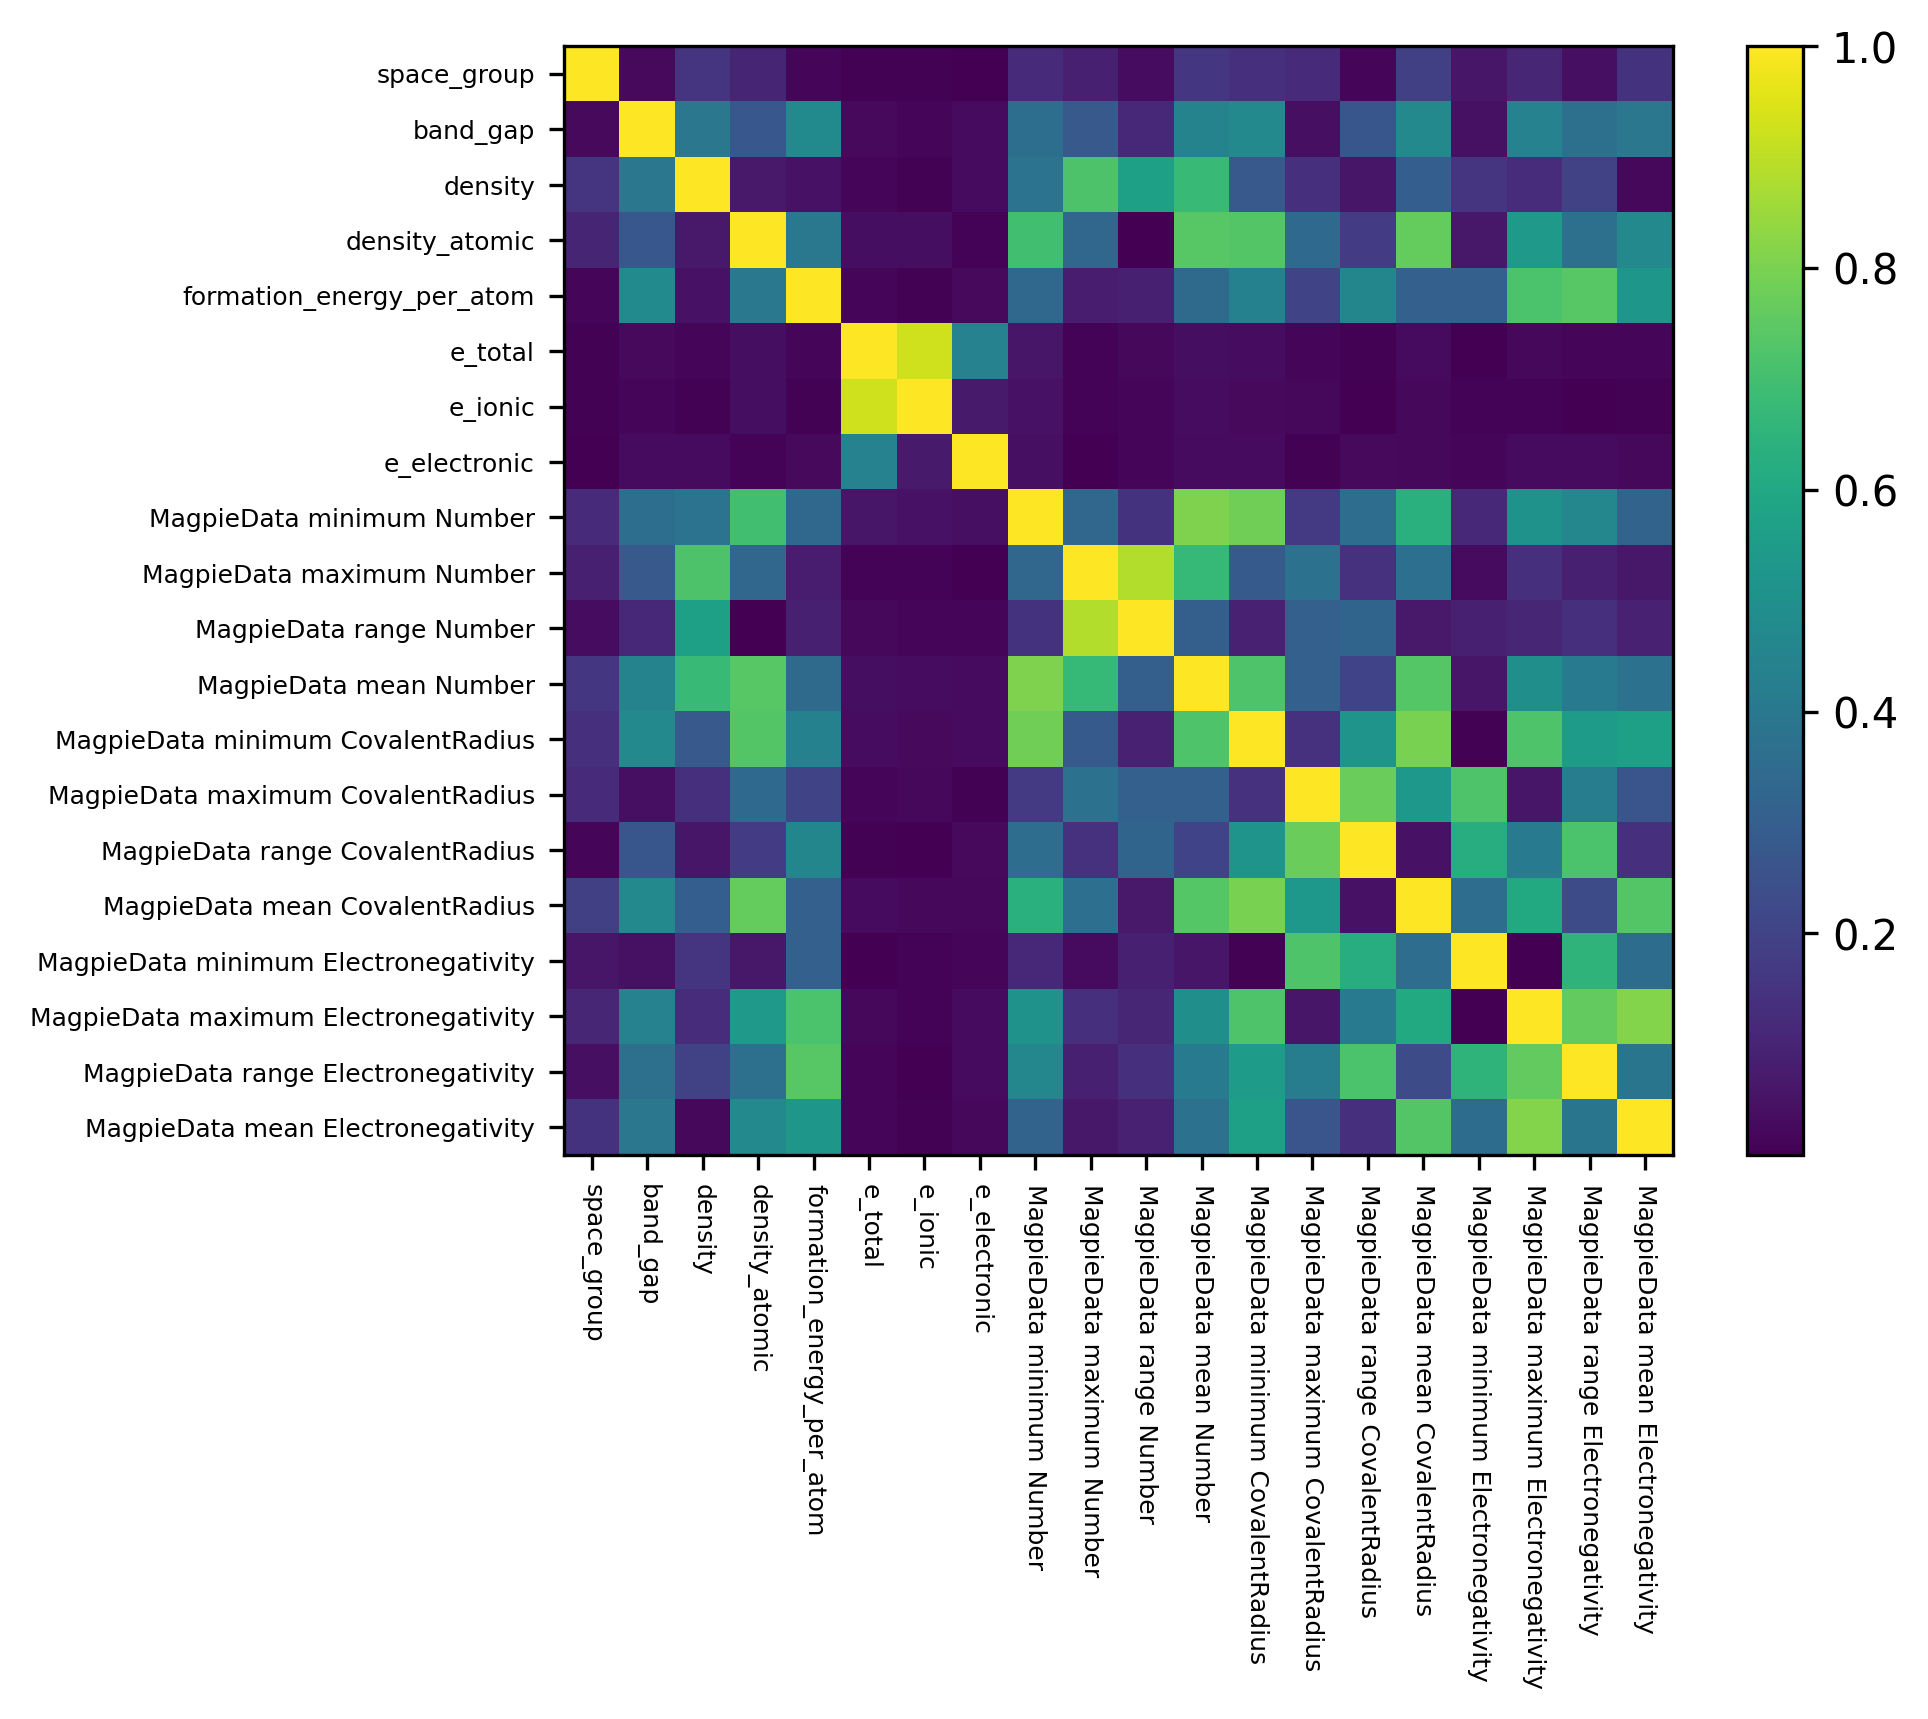

In [3]:
# 导入数据
data_featurized = pd.read_csv('../data/data_training.csv')

corr_matrix = data_featurized.corr(numeric_only=True).abs()   # we take the absolute value
fig, ax = plt.subplots(dpi=300)
h = ax.imshow(corr_matrix)
# 设置坐标名称
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, fontsize=6, rotation=-90)
ax.set_yticklabels(corr_matrix.columns, fontsize=6)
plt.colorbar(h)
plt.show()

#### 1. 进行特征缩放，归一化

In [7]:
data_featurized.drop(columns=['material_id', 'composition', 'crystal_system'], inplace=True)
data_featurized.head()

,space_group,band_gap,density,density_atomic,formation_energy_per_atom,e_total,e_ionic,e_electronic,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity
0,11,0.7792,5.022717,22.595815,-1.124079,17.048334,7.118969,9.929365,16.0,56.0,40.0,30.285714,105.0,215.0,110.0,130.428571,0.89,2.58,1.69,2.230000
1,19,2.8980,3.764366,15.869706,-3.099174,17.572010,13.469477,4.102533,8.0,41.0,33.0,16.500000,57.0,164.0,107.0,88.250000,1.60,3.98,2.38,3.115000
2,1,1.7212,3.094976,28.031499,-0.766100,18.488667,12.443616,6.045051,16.0,38.0,22.0,24.000000,105.0,195.0,90.0,121.857143,0.95,2.58,1.63,2.232857
3,12,2.0944,2.901260,12.923684,-1.948264,9.596025,6.499905,3.096120,8.0,26.0,18.0,11.083333,66.0,166.0,100.0,86.333333,0.93,3.44,2.51,2.953333
4,62,7.4812,1.860992,9.355010,-1.970766,6.216546,4.350314,1.866232,1.0,9.0,8.0,5.200000,31.0,84.0,53.0,50.700000,2.04,3.98,1.94,2.980000


In [9]:
X = data_featurized.drop(columns=['e_total', 'e_ionic', 'e_electronic'])

In [20]:
y_e_total = data_featurized['e_total']
y_e_ionic = data_featurized['e_ionic']
y_e_eletronic = data_featurized['e_electronic']

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# 保存X_scaled
# 使用np.save()函数将NumPy数组保存为.npy文件
np.save('../data/X_scaled.npy', X_scaled)
# 保存y值
y = data_featurized[['e_total', 'e_ionic', 'e_electronic']]
y.to_csv('../data/y.csv', index=False)

#### 2. 训练集测试集划分

In [21]:
# 训练集测试集划分
# 这里使用y_e_eletronic作为目标值
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_e_eletronic, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 进行模型训练

In [23]:
def model_cross_train(model, X, y):
    '''在X上训练模型model，返回交叉验证的结果：
        1. scores（neg_root_mean_squared_error）
        2. y_hat'''
    # 进行k折交叉验证
    # cross_val_predict()函数不会改变原始的模型。这个函数的主要目的是使用交叉验证来为每个输入数据点生成预测值。
    kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
    y_hat = cross_val_predict(model, X, y, cv=kfold)
    return scores, y_hat

In [24]:
# 确定好全部超参数后，使用最优的超参数在整个训练集上训练模型
def model_final_train(model, X_train, y_train):
    '''在整个训练集上训练模型model，返回训练好的模型'''
    model.fit(X_train, y_train)
    return model

def model_test(model, X_test, y_test):
    '''在测试集上测试模型model，返回测试结果：
        1. mean_squared_error
        2. mean_absolute_error
        3. y_pred'''
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, mae, ypred

#### 1. LinearRegression模型 

MSE: -295.4557681448467


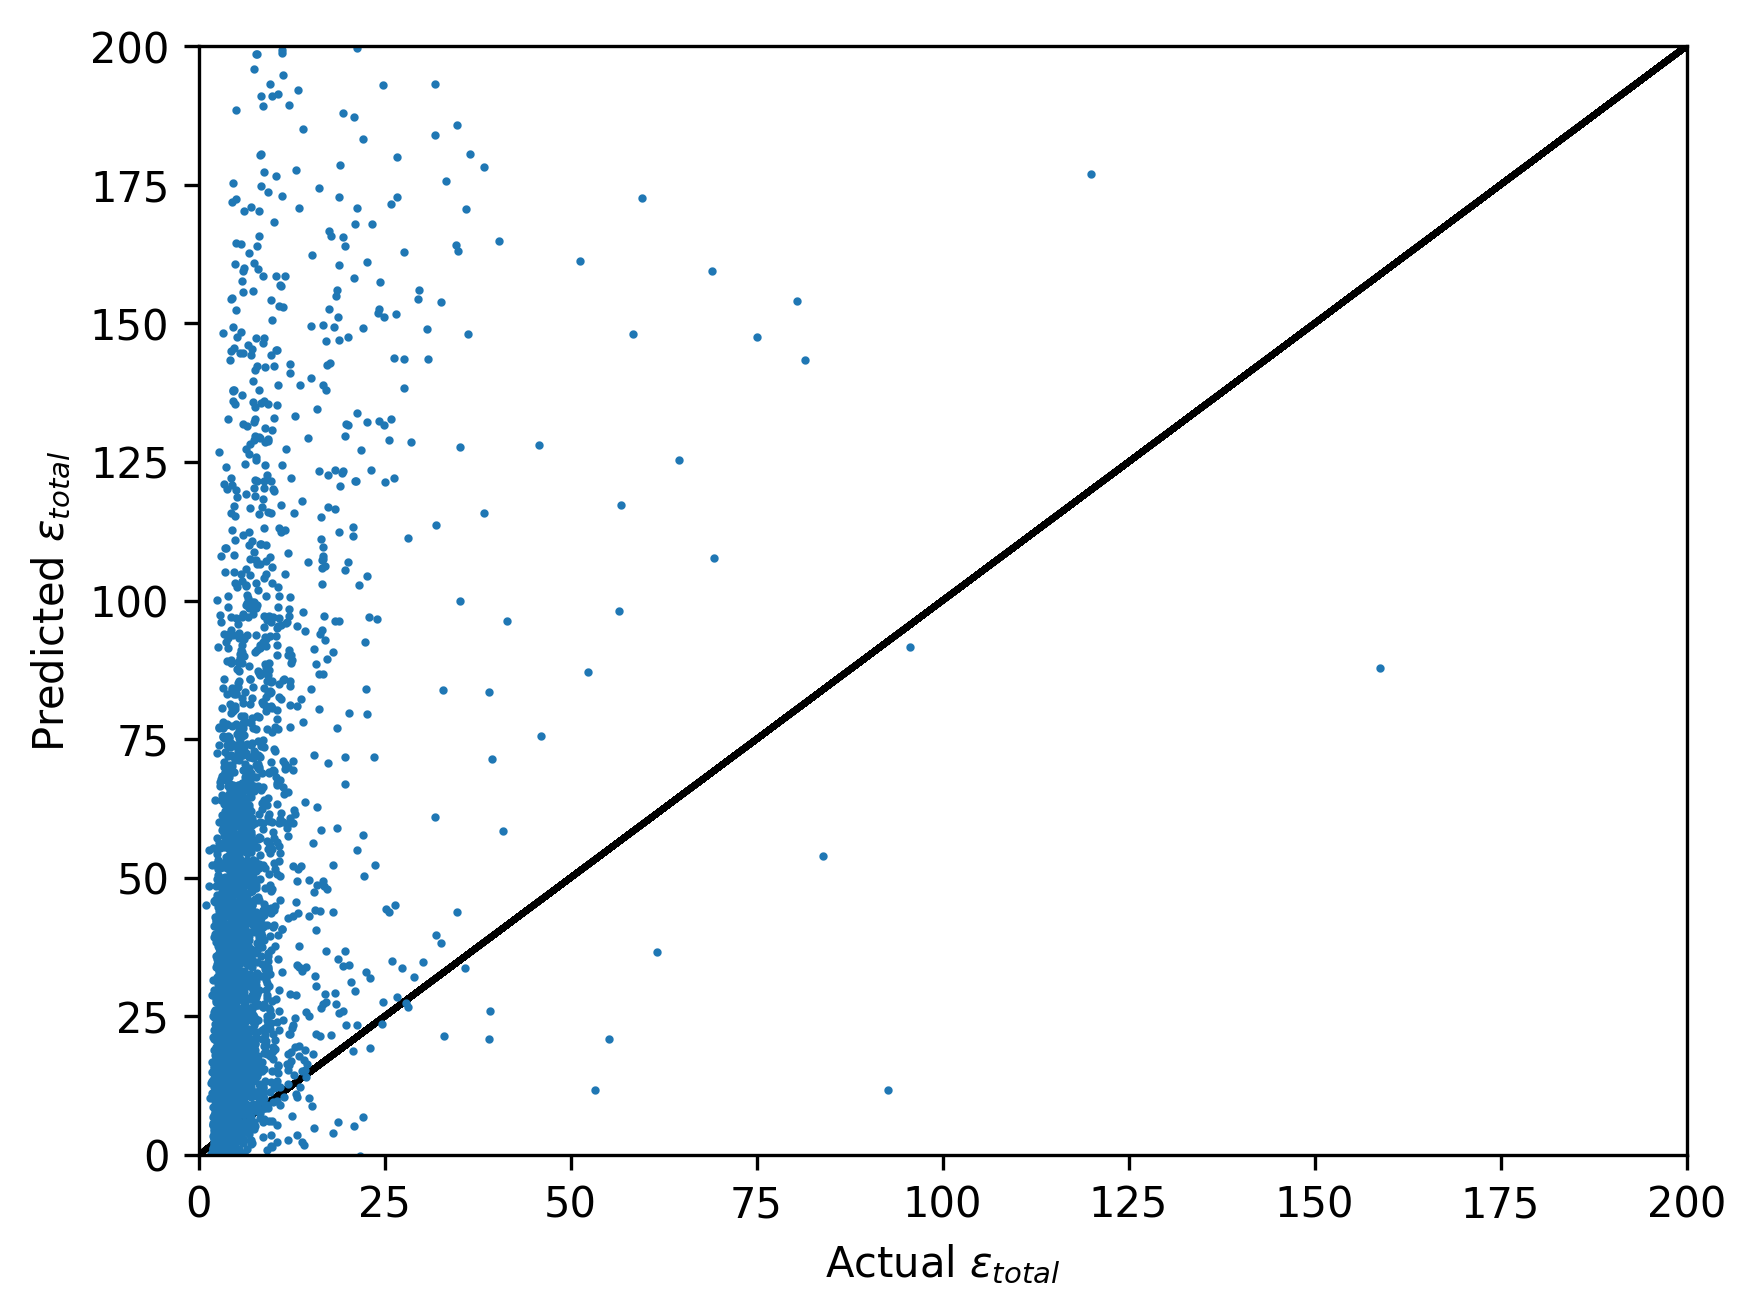

In [25]:
# 这个模型使用解析解，故不包含学习率的设置
lr = LinearRegression()
scores, y_hat = model_cross_train(lr, X_train, y_train)

def plot_cross_val_scores(scores, y_hat):
    '''绘制交叉验证的结果'''
    print(f'MSE: {scores.mean()}')

    # 绘制parity plot
    fig, ax = plt.subplots(dpi=300)
    ax.scatter(y_train, y_hat, s=1)
    ax.plot(y_train, y_train, c='k', zorder=-5)
    ax.set_xlabel('Actual $\epsilon_{electronic}$')
    ax.set_ylabel('Predicted $\epsilon_{electronic}$')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 200)
    plt.show()
    return fig

fig = plot_cross_val_scores(scores, y_hat)


#### 2. 决策树模型


MSE: -272.50463108989265


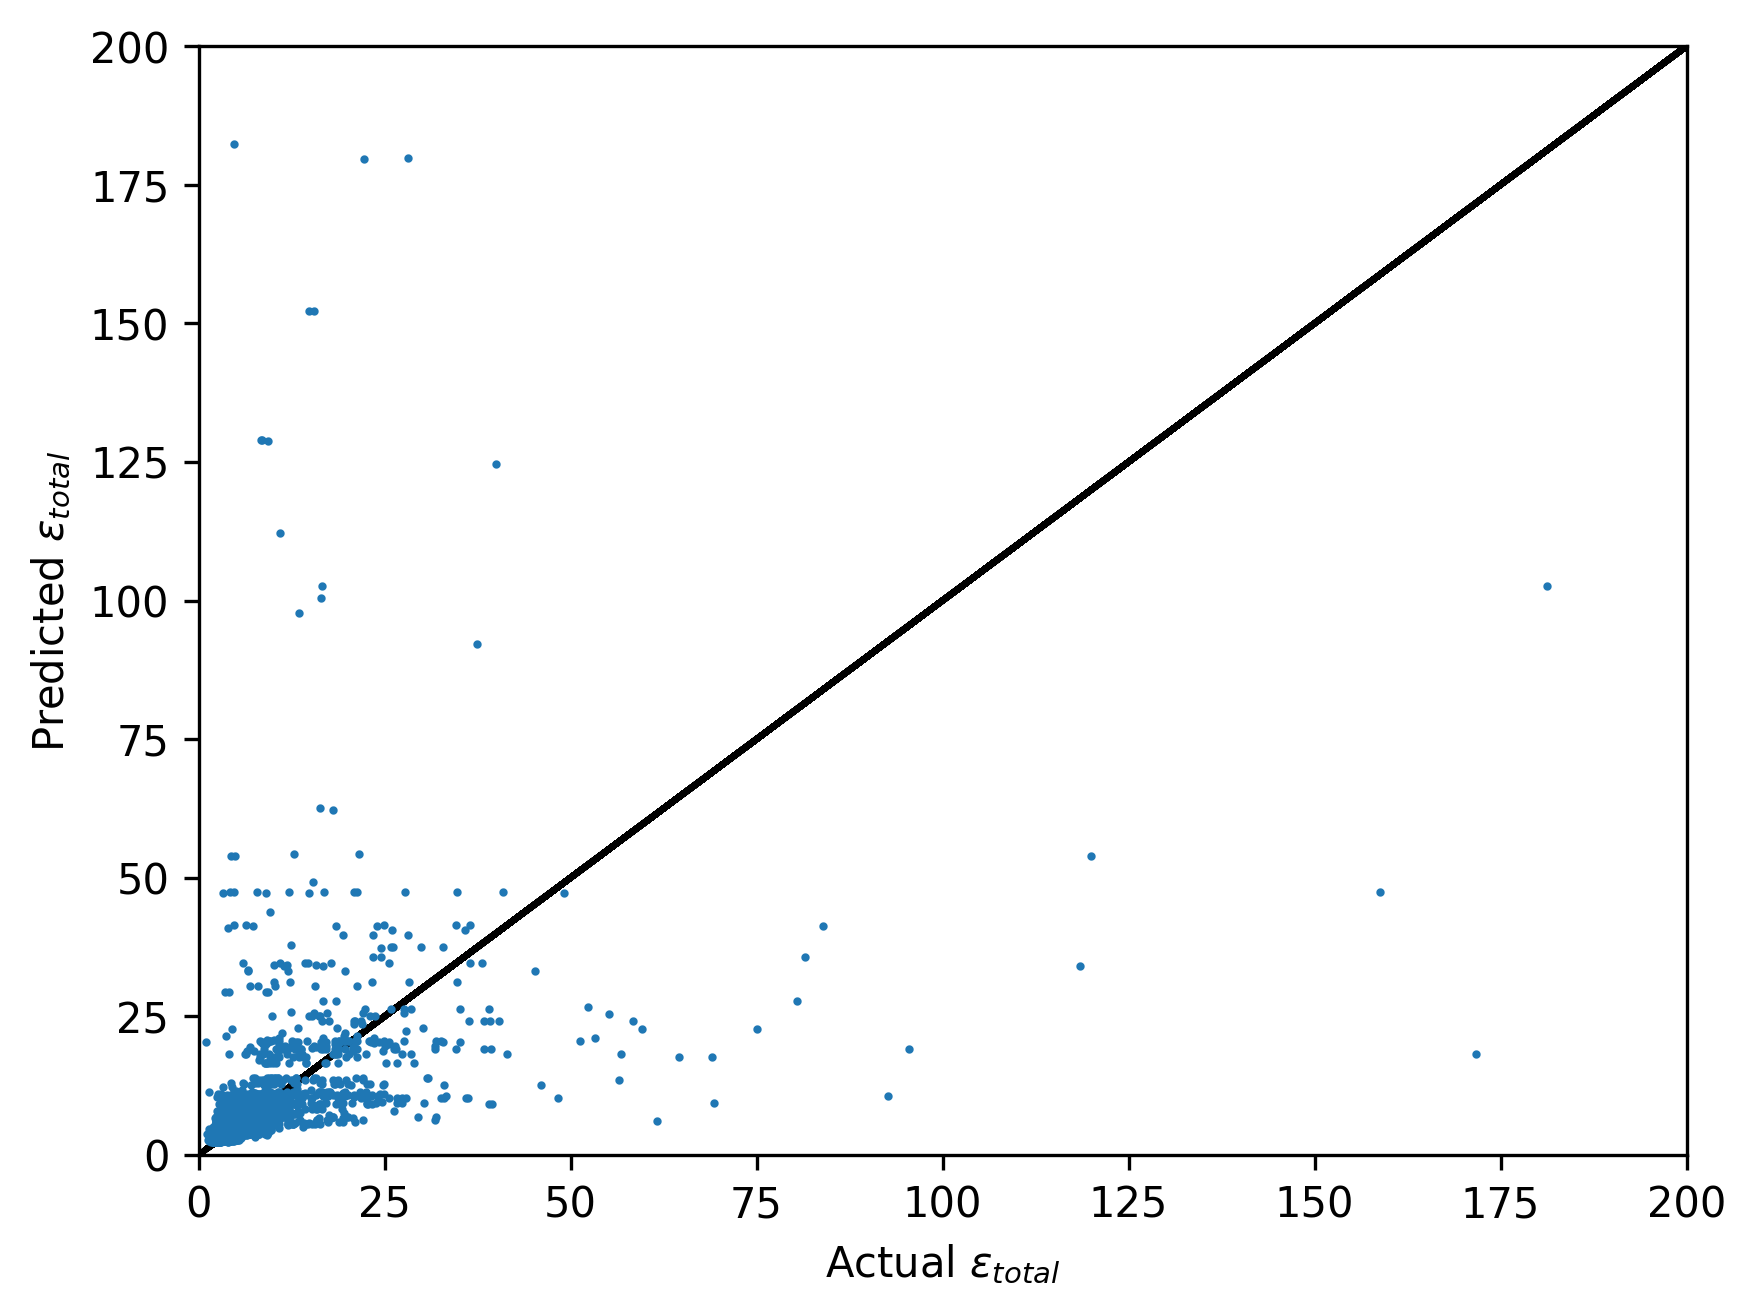

Best depth: 6


In [26]:
from sklearn.tree import DecisionTreeRegressor, plot_tree       # ML model

# 确定超参数MAX_DEPTH后，使用最优的超参数在整个训练集上训练模型
max_scores=-1e5
BEST_DEPTH=0
for depth in range(6, 15):
    dt = DecisionTreeRegressor(max_depth=depth,random_state=RANDOM_STATE)      # decision tree constructor
    scores, y_hat = model_cross_train(dt, X_train, y_train)                              
    if scores.mean() > max_scores:
        max_scores = scores.mean()
        BEST_DEPTH = depth
        plot_cross_val_scores(scores, y_hat)

print(f'Best depth: {BEST_DEPTH}')

#### 3. 随机森林算法

MSE: -592.5404377458474


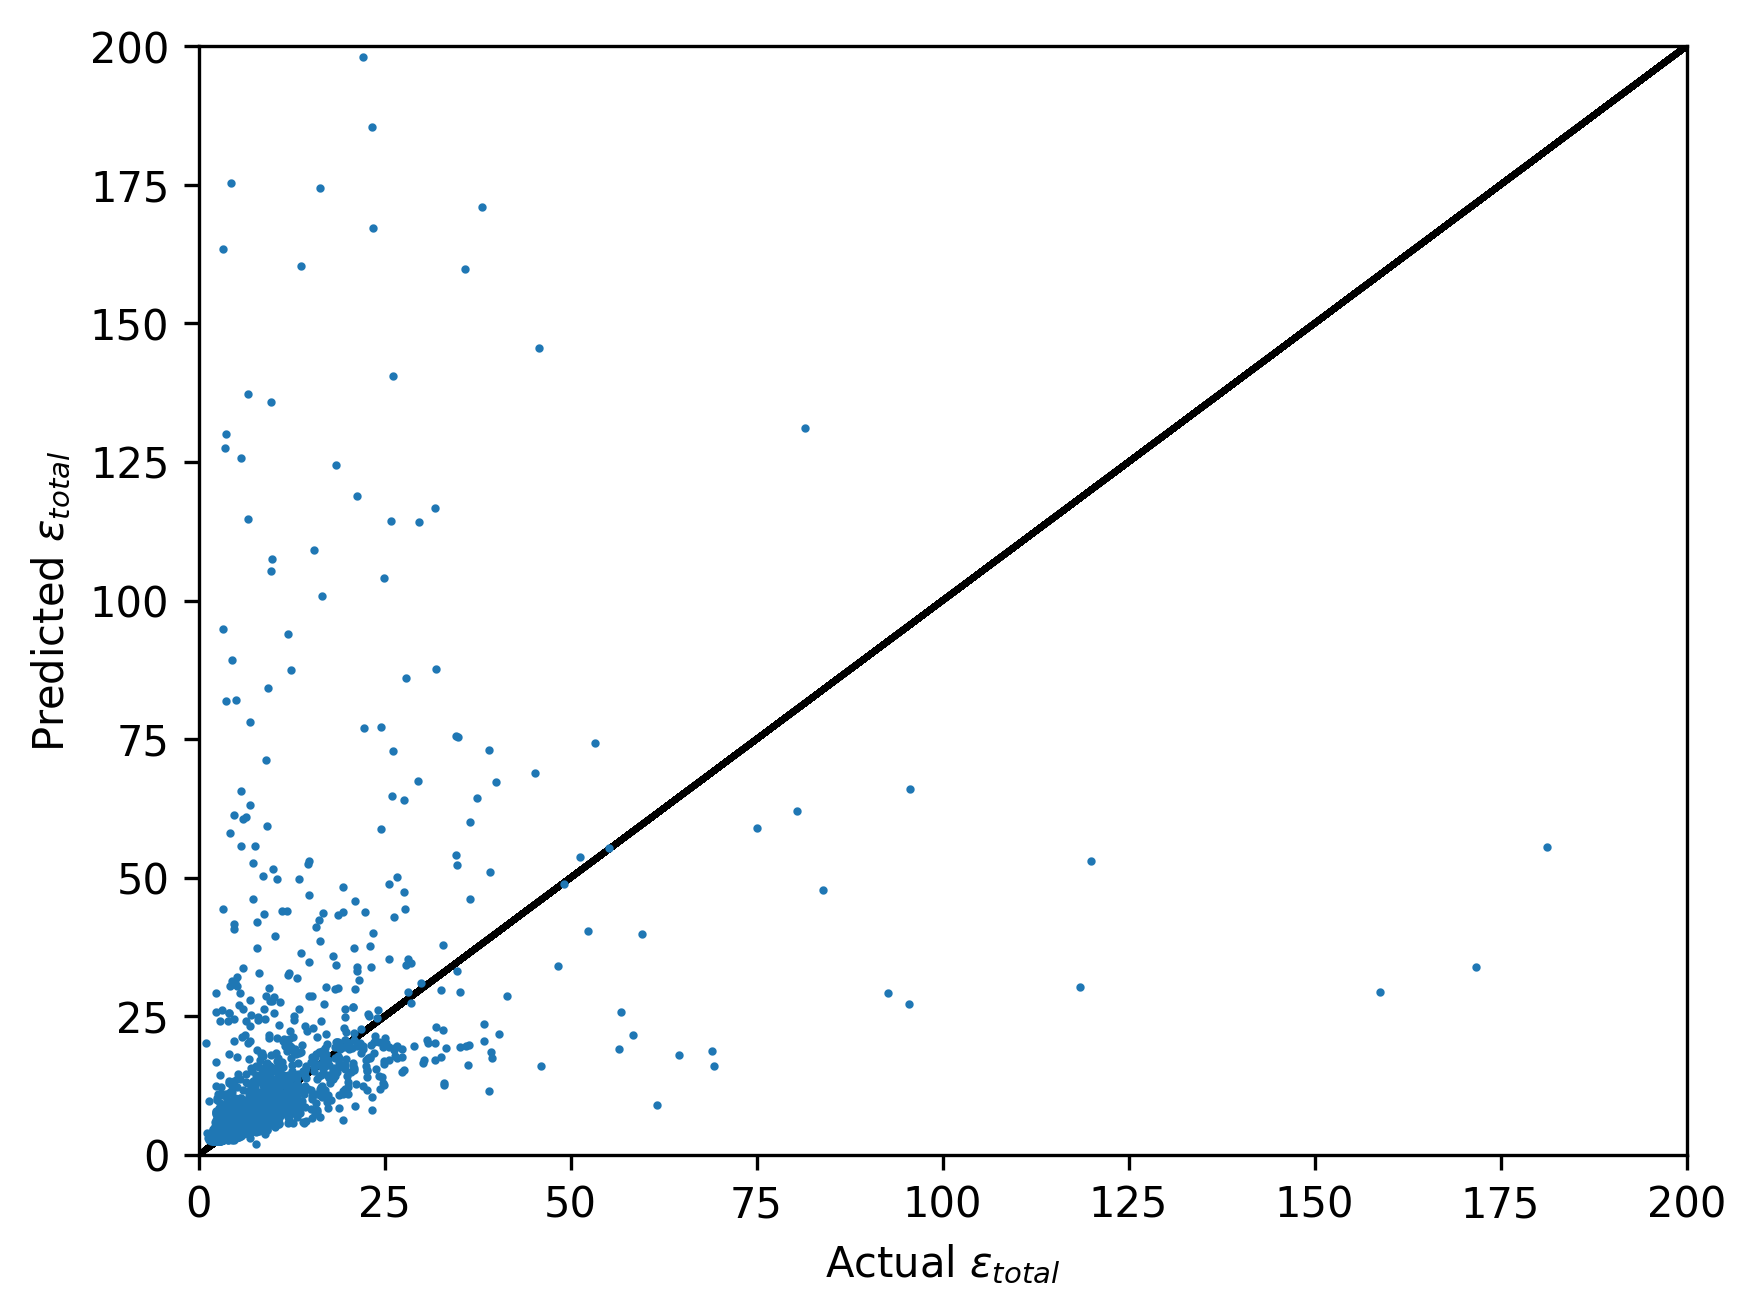

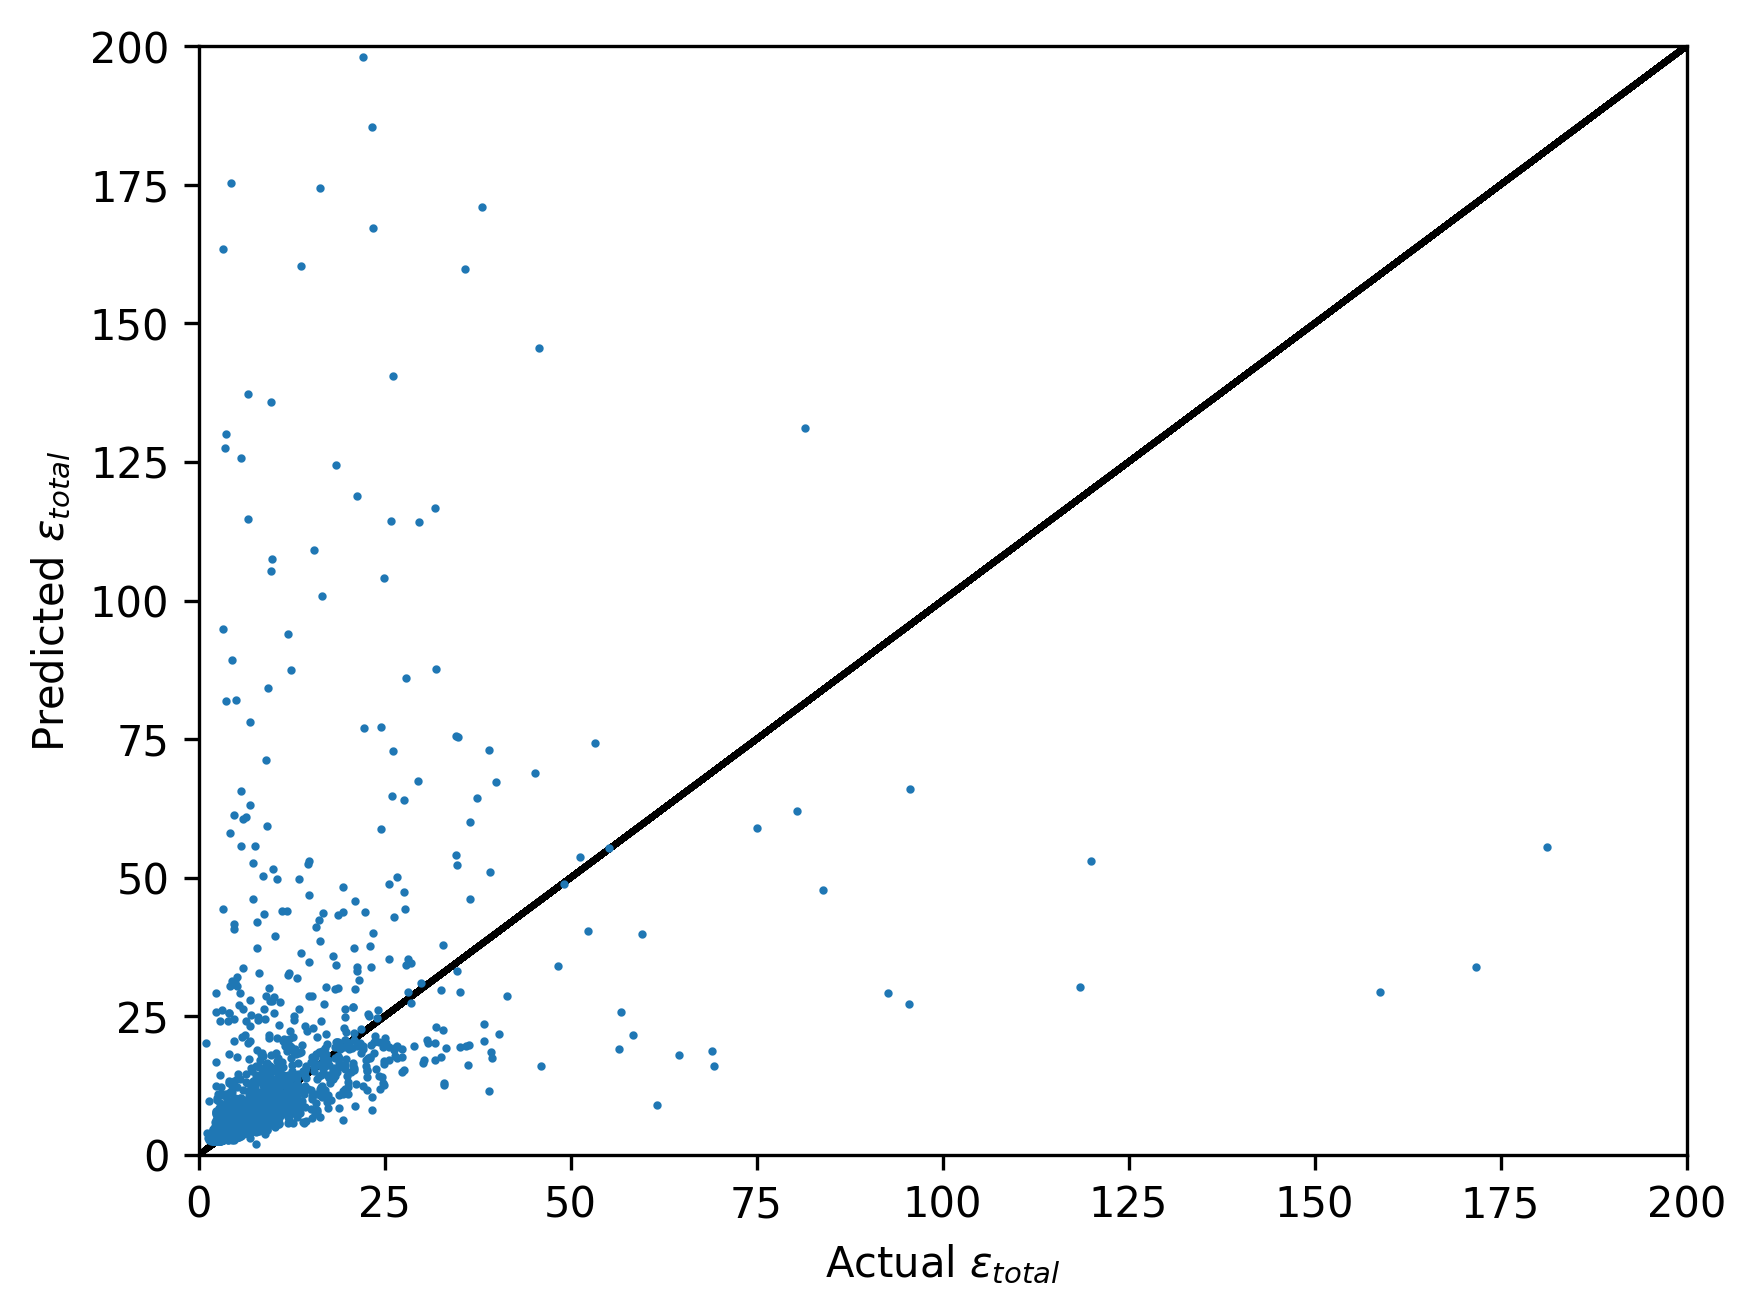

In [27]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=BEST_DEPTH, random_state=RANDOM_STATE)
scores, y_hat = model_cross_train(rf, X_train, y_train)
plot_cross_val_scores(scores, y_hat)

#### 4. 使用神经网络

In [29]:
# 加载数据
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets.to_numpy().reshape(-1, 1)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # 根据索引获取数据和目标，并将它们转换为张量
        x = torch.tensor(self.data[index], dtype=torch.float32)
        y = torch.tensor(self.targets[index], dtype=torch.float32)
        return x, y
    
# 创建自定义数据集实例
dataset = CustomDataset(X_train, y_train)   # 注意X_train,y_train都为pandas.DataFrame
# 创建数据加载器
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [30]:
X_train.shape

(5093, 17)

In [31]:
# 搭建神经网络
import torch.nn as nn
# 导入optim
import torch.optim as optim

class NN_model(nn.Module):
    def __init__(self):
        super(NN_model, self).__init__()
        
        # 使用Sequential定义神经网络的结构
        self.layers = nn.Sequential(
            nn.Linear(17, 9),
            nn.ReLU(),
            nn.Linear(9, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )
        
    def forward(self, x):
        # 前向传播
        return self.layers(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
# 定义超参数
input_size = 17
output_size = 1
learning_rate = 0.002
num_epochs = 1000

# 初始化模型、损失函数和优化器
model = NN_model()
# 使用均方误差作为损失函数
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)
criterion.to(device)
# 训练模型
model.train()
for epoch in range(num_epochs):
    # Forward pass
    epoch_loss = 0
    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)
        outputs = model(features)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        # Backward and optimize
        optimizer.zero_grad()    # 梯度重置
        loss.backward() # 向后传播计算梯度
        optimizer.step() # 通过梯度更新参数

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, MSE: {epoch_loss/len(dataset):.4f}')

cuda
Epoch [100/1000], Loss: 43823129.8766, MSE: 8604.5808
Epoch [200/1000], Loss: 43087510.5440, MSE: 8460.1434
Epoch [300/1000], Loss: 42155143.9982, MSE: 8277.0752
Epoch [400/1000], Loss: 41105692.3485, MSE: 8071.0175
Epoch [500/1000], Loss: 39880064.7902, MSE: 7830.3681
Epoch [600/1000], Loss: 38437217.9538, MSE: 7547.0681
Epoch [700/1000], Loss: 36970679.8203, MSE: 7259.1164
Epoch [800/1000], Loss: 35285449.2144, MSE: 6928.2249
Epoch [900/1000], Loss: 33339128.6544, MSE: 6546.0689
Epoch [1000/1000], Loss: 36937349.6021, MSE: 7252.5721


In [32]:
# 继续训练
# 训练模型
model.train()
for epoch in range(num_epochs*2):
    # Forward pass
    epoch_loss = 0
    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)
        outputs = model(features)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        # Backward and optimize
        optimizer.zero_grad()    # 梯度重置
        loss.backward() # 向后传播计算梯度
        optimizer.step() # 通过梯度更新参数

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs*2}], Loss: {epoch_loss:.4f}, MSE: {epoch_loss/len(dataset):.4f}')

Epoch [100/2000], Loss: 29560284.7685, MSE: 5804.1007
Epoch [200/2000], Loss: 27187405.4414, MSE: 5338.1907
Epoch [300/2000], Loss: 25117902.1723, MSE: 4931.8481
Epoch [400/2000], Loss: 22326912.8647, MSE: 4383.8431
Epoch [500/2000], Loss: 19660773.6878, MSE: 3860.3522
Epoch [600/2000], Loss: 17114247.4179, MSE: 3360.3470
Epoch [700/2000], Loss: 14519006.0872, MSE: 2850.7768
Epoch [800/2000], Loss: 11868329.1171, MSE: 2330.3218
Epoch [900/2000], Loss: 9451353.4613, MSE: 1855.7537
Epoch [1000/2000], Loss: 7252650.5136, MSE: 1424.0429
Epoch [1100/2000], Loss: 5488823.3611, MSE: 1077.7191
Epoch [1200/2000], Loss: 4233896.2313, MSE: 831.3168
Epoch [1300/2000], Loss: 3344667.5245, MSE: 656.7185
Epoch [1400/2000], Loss: 2789830.3806, MSE: 547.7774
Epoch [1500/2000], Loss: 2239093.7100, MSE: 439.6414
Epoch [1600/2000], Loss: 1762977.7768, MSE: 346.1570
Epoch [1700/2000], Loss: 1329563.8319, MSE: 261.0571
Epoch [1800/2000], Loss: 1008266.1594, MSE: 197.9710
Epoch [1900/2000], Loss: 609583.8336

In [45]:
y_train.shape

(5093,)

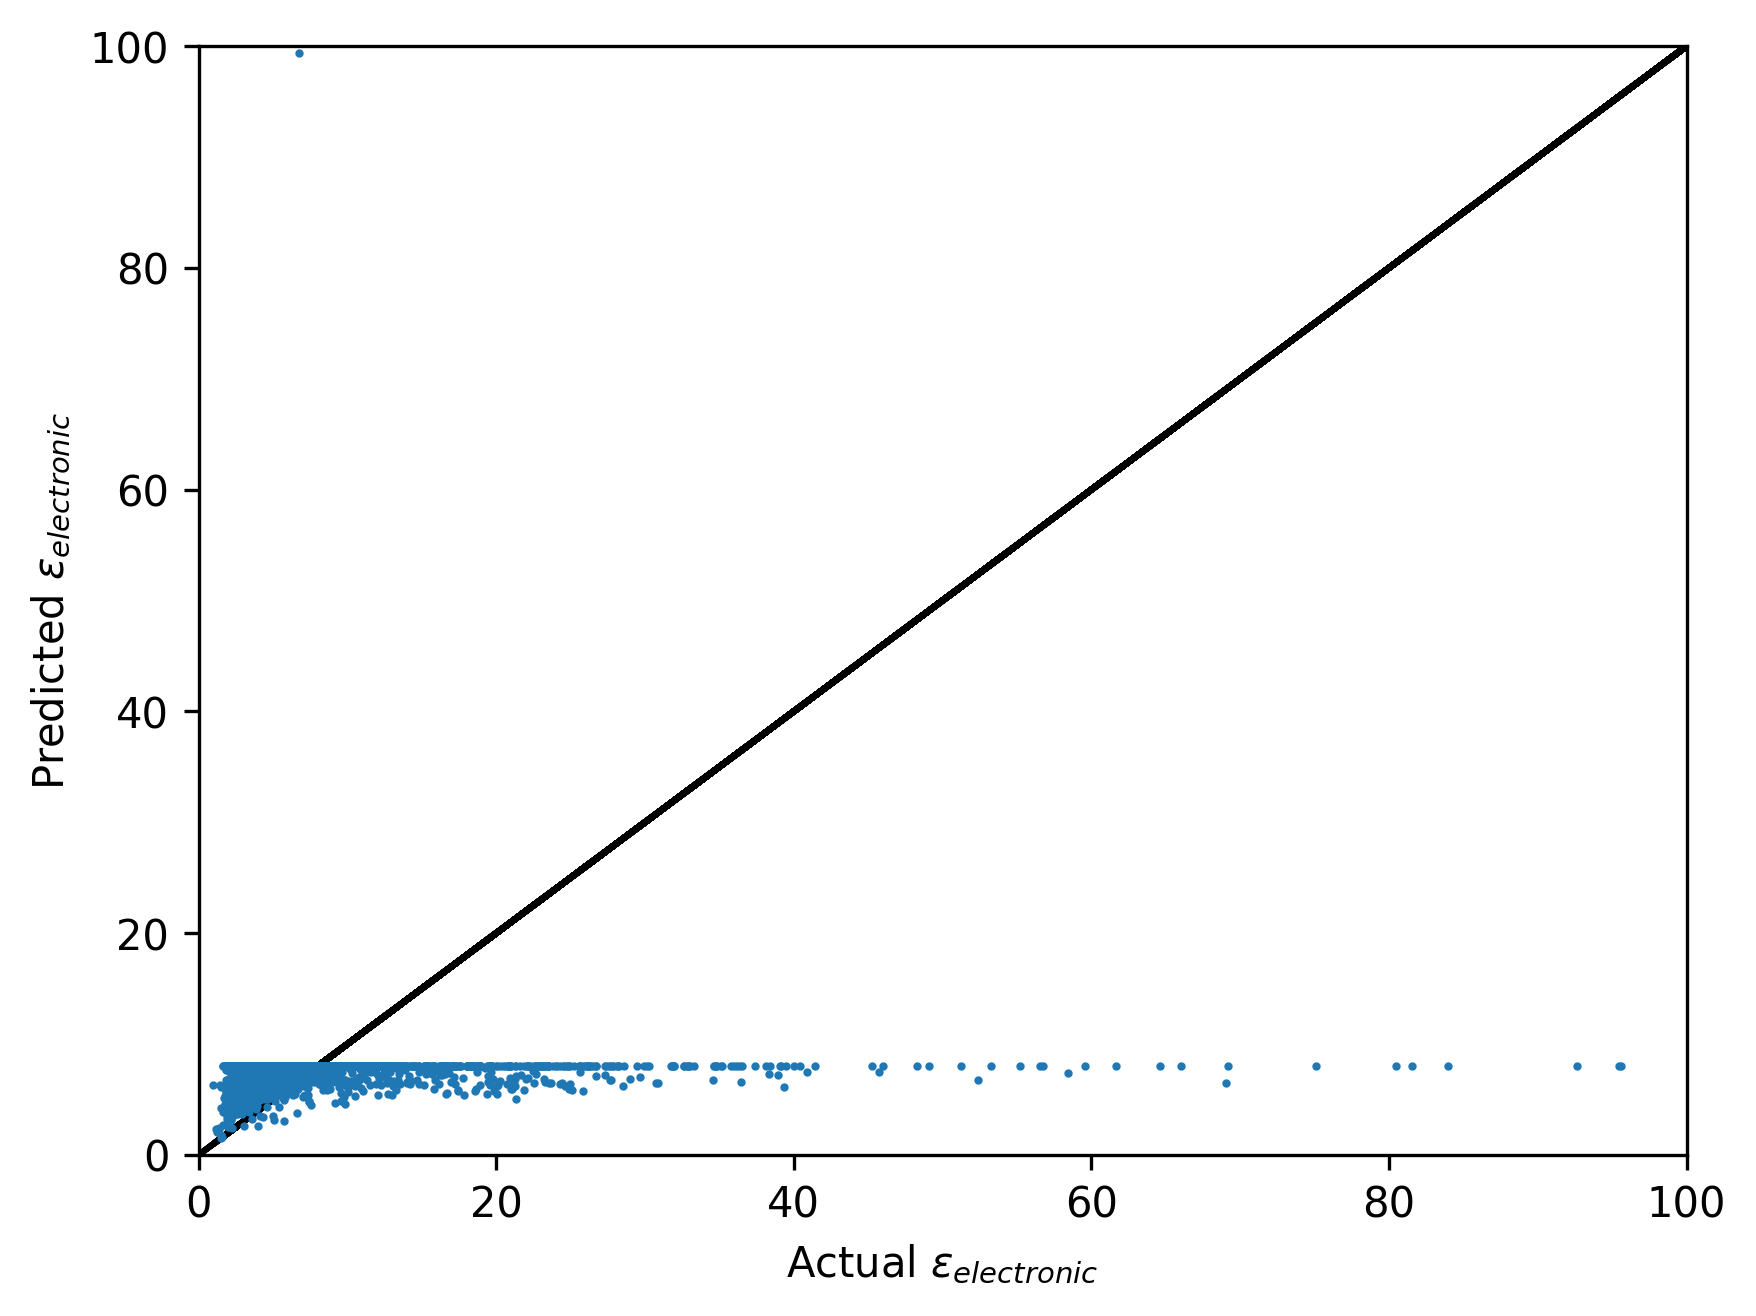

In [48]:
y_hat = model(torch.tensor(X_train, dtype=torch.float32).to(device)).cpu().detach().numpy()
# 绘制parity plot
fig, ax = plt.subplots(dpi=300)
ax.scatter(y_train, y_hat, s=1)
ax.plot(y_train, y_train, c='k', zorder=-5)
ax.set_xlabel('Actual $\epsilon_{electronic}$')
ax.set_ylabel('Predicted $\epsilon_{electronic}$')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.show()

In [49]:
# 保存模型
torch.save(model.state_dict(), 'NN_model_e_electronic.pth')